# Stock Prices Prediction Using XGBoost

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import yfinance as yf
import time
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error
import warnings
warnings.filterwarnings("ignore")

In [2]:
# Accquiring stock data starting from 30 July 2020 to 27 August 2022 and preview the data
stock_data = yf.download('BYDDY', start='2020-07-31', end='2022-08-27')
stock_data

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2020-07-30,18.709999,18.969999,18.580000,18.730000,18.705582,88600
2020-07-31,19.020000,19.100000,18.799999,18.889999,18.865374,48400
2020-08-03,19.330000,19.410000,19.209999,19.299999,19.274837,124000
2020-08-04,19.850000,20.139999,19.820000,20.080000,20.053823,57500
2020-08-05,20.180000,20.290001,20.090000,20.160000,20.133718,60200
...,...,...,...,...,...,...
2022-08-22,69.800003,70.519997,69.800003,70.199997,70.199997,77400
2022-08-23,69.000000,69.809998,67.889999,69.019997,69.019997,158700
2022-08-24,66.690002,67.550003,66.000000,67.070000,67.070000,138700


In [3]:
stock_data = stock_data[["Close"]].copy()
stock_data

,Close
Date,
2020-07-30,18.730000
2020-07-31,18.889999
2020-08-03,19.299999
2020-08-04,20.080000
2020-08-05,20.160000
...,...
2022-08-22,70.199997
2022-08-23,69.019997
2022-08-24,67.070000


Text(0, 0.5, 'Prices ($)')

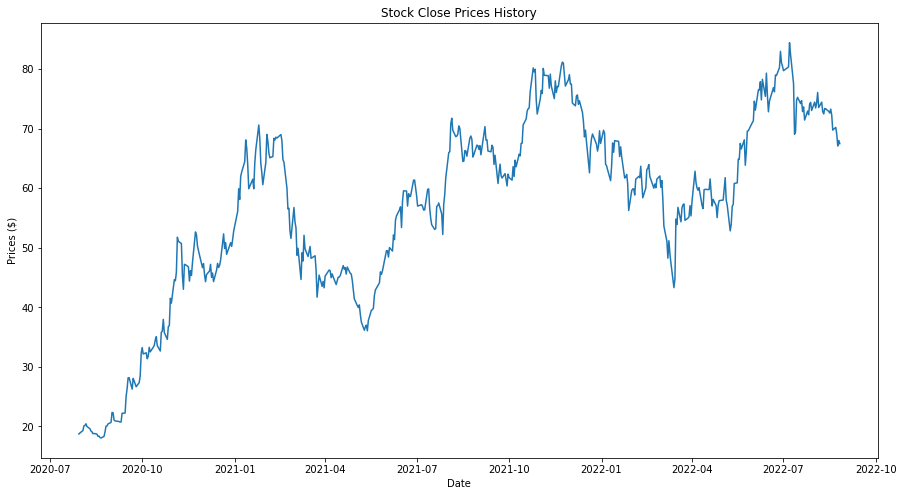

In [4]:
# Visualizing Stock Prices History

plt.figure(figsize=(15, 8))              # Setting up the plot figure size
plt.title('Stock Close Prices History')  # Setting up the plot figure title
plt.plot(stock_data['Close'])            # Create a line chart for historical close prices
plt.xlabel('Date')                       # Set the x-axis and y-axis labels
plt.ylabel('Prices ($)')

In [5]:
stock_data["target"] = stock_data.Close.shift(-1)
stock_data.dropna(inplace=True)
stock_data

,Close,target
Date,,
2020-07-30,18.730000,18.889999
2020-07-31,18.889999,19.299999
2020-08-03,19.299999,20.080000
2020-08-04,20.080000,20.160000
2020-08-05,20.160000,20.440001
...,...,...
2022-08-19,69.750000,70.199997
2022-08-22,70.199997,69.019997
2022-08-23,69.019997,67.070000


In [6]:
def train_test_split(data, perc):
    data = data.values
    n = int(len(data) * (1-perc)) 
    return data[:n], data[n:], n

In [7]:
train, test, n = train_test_split(stock_data, 0.2)
print(len(stock_data))
print(len(train))
print(len(test))

523
418
105


We'll use the XGBRegressor class to make a prediction, XGBRegressor is an implementaiton of the scikit-learn API for XGBoost regression

We'll take the train set and test input row as input, fit a model and make a prediction

### Predict

Train on train set and predict one sample at a time

In [8]:
model = XGBRegressor(objective="reg:squarederror", n_estimators=175)

def xgb_predict(train, val):
    train = np.array(train)
    X_train, y_train = train[:, :-1], train[:, -1]
    model.fit(X_train, y_train)
    
    val = np.array(val).reshape(1, -1)
    pred = model.predict(val)
    return pred[0]

### Walk-forward validation

Since we are making a one step forward prediction, in this case the prediction we will predict the first record in the test dataset. Afterwards we add the real observation from the test set to the train set, refit the model, then predict the next step in the test dataset. We'll evaluate the model using RMSE metric.

In [9]:
def validate(data, perc):
    predictions = []
    
    train, test, n = train_test_split(data, perc)
    
    history = [x for x in train]
                
    for i in range(len(test)):
        test_X, test_y = test[i, :-1], test[i, -1]
                  
        pred = xgb_predict(history, test_X)
        predictions.append(pred)
                  
        history.append(test[i])
                         
    return test[:, -1], predictions

In [10]:
%%time
y_test, pred = validate(stock_data,0.2)

CPU times: total: 3min
Wall time: 28.2 s


In [11]:
# Apply the RMSE formula to calculate the degree of discrepancy between the predicted prices and real prices (y_test) and display the result
rmse = np.sqrt(pow(np.mean(pred - y_test),2))

# Apply the RMSE formula to calculate the degree of discrepancy between the predicted prices and real prices (y_test) and display the result
mape = np.mean(np.abs((y_test - pred) / y_test)) * 100

# Calculate RMSE
print("RMSE on test set = %0.4f" % rmse)

# Calculate MAPE
print("MAPE on test set = %0.4f%%" % mape)

RMSE on test set = 0.1331
MAPE on test set = 3.0618%


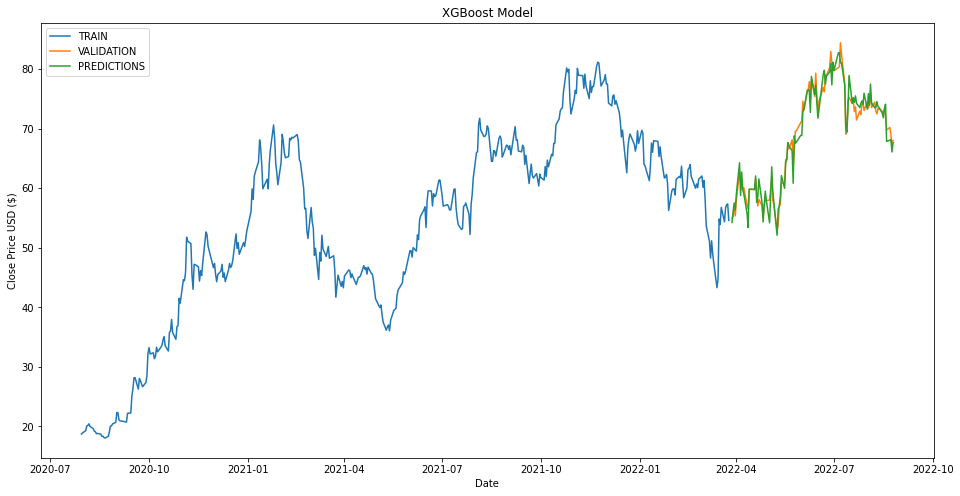

In [12]:
# Visualizing the Predicted Prices

# Use the filter method to only retain the closing price column in the dataframe
data = stock_data.filter(['Close'])

# Split our stock data into three plotting regions: training, validation and prediction
train = data[:n]
validation = data[n:]
validation ['Predictions'] = pred

# Configure the chart figure size, title, x-axis & y-axis label and legends
plt.figure(figsize=(16,8))
plt.title('XGBoost Model')
plt.xlabel('Date')
plt.ylabel('Close Price USD ($)')
plt.plot(train)
plt.plot(validation[['Close', 'Predictions']])
plt.legend(['TRAIN', 'VALIDATION', 'PREDICTIONS'], loc='upper left')
plt.show()

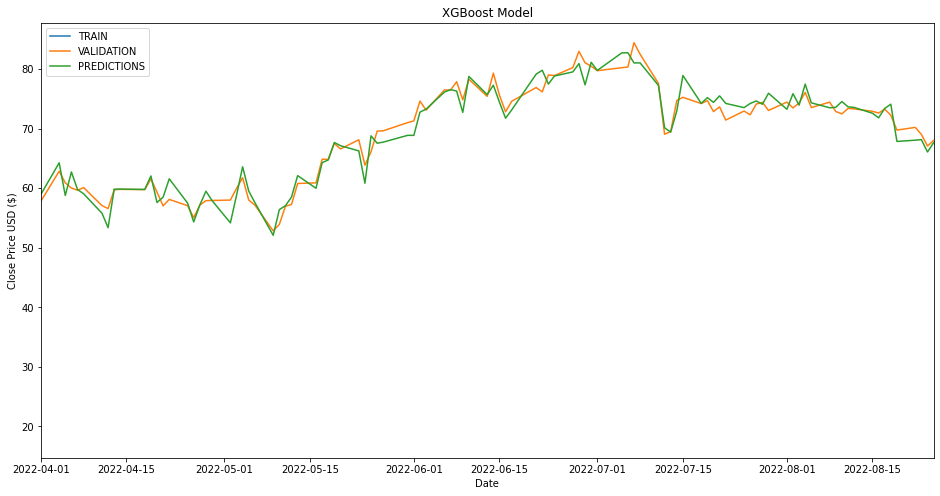

In [13]:
# Visualizing the Predicted Prices

import time
from datetime import date

# Use the filter method to only retain the closing price column in the dataframe
data = stock_data.filter(['Close'])

# Split our stock data into three plotting regions: training, validation and prediction
train = data[:n]
validation = data[n:]
validation ['Predictions'] = pred

# Configure the chart figure size, title, x-axis & y-axis label and legends
plt.figure(figsize=(16,8))
plt.title('XGBoost Model')
plt.xlabel('Date')
plt.ylabel('Close Price USD ($)')
plt.plot(train)
plt.plot(validation[['Close', 'Predictions']])
plt.legend(['TRAIN', 'VALIDATION', 'PREDICTIONS'], loc='upper left')
plt.xlim([date(2022, 4, 1), date(2022, 8, 25)])
plt.show()

In [14]:
stock_data1 = pd.read_csv("BYDDY_stocks.csv")
stock_data1

,Date,Open,High,Low,Close,Adj Close,Volume
0,2020-07-30,18.709999,18.969999,18.580000,18.730000,18.705582,88600
1,2020-07-31,19.020000,19.100000,18.799999,18.889999,18.865374,48400
2,2020-08-03,19.330000,19.410000,19.209999,19.299999,19.274839,124000
3,2020-08-04,19.850000,20.139999,19.820000,20.080000,20.053823,57500
4,2020-08-05,20.180000,20.290001,20.090000,20.160000,20.133717,60200
...,...,...,...,...,...,...,...
519,2022-08-22,69.800003,70.519997,69.800003,70.199997,70.199997,77400
520,2022-08-23,69.000000,69.809998,67.889999,69.019997,69.019997,158700
521,2022-08-24,66.690002,67.550003,66.000000,67.070000,67.070000,138700
522,2022-08-25,67.150002,68.010002,66.220001,68.010002,68.010002,274600


In [15]:
stock_data1.iloc[-1]

Date         2022-08-26
Open          68.620003
High          69.239998
Low           67.360001
Close         67.470001
Adj Close     67.470001
Volume           227100
Name: 523, dtype: object

In [16]:
X_input = stock_data.iloc[-60:].Close.values               # getting last rows and converting to array
X_input = (X_input.reshape(-1,1))                         # converting to 2D array
X_input = np.reshape(X_input, (60,1))
print("Shape of X_input :", X_input.shape)
X_input

Shape of X_input : (60, 1)


array([[71.29000092],
       [74.61000061],
       [73.09999847],
       [76.48000336],
       [76.47000122],
       [77.87000275],
       [74.80999756],
       [78.27999878],
       [75.41000366],
       [79.30999756],
       [75.59999847],
       [72.81999969],
       [74.58000183],
       [76.88999939],
       [76.16999817],
       [79.        ],
       [78.90000153],
       [80.23999786],
       [82.95999908],
       [81.05000305],
       [80.48000336],
       [79.72000122],
       [80.22000122],
       [80.33999634],
       [84.41999817],
       [82.48999786],
       [77.58000183],
       [69.05000305],
       [69.5       ],
       [74.70999908],
       [75.25      ],
       [74.19999695],
       [74.69999695],
       [72.84999847],
       [73.63999939],
       [71.43000031],
       [72.94000244],
       [72.31999969],
       [74.12000275],
       [74.40000153],
       [73.04000092],
       [74.44999695],
       [73.45999908],
       [74.31999969],
       [76.05999756],
       [73

In [17]:
XGBoost_prediction = model.predict(X_input)
print("XGBoost prediction, Close price prediction for 29/8/2022 :", XGBoost_prediction[0])

XGBoost prediction, Close price prediction for 29/8/2022 : 74.147255


In [18]:
# Accquiring stock data starting from 29 August 2022 to 30 August 2022 and preview the data
stock_data2 = yf.download('BYDDY', start='2022-08-29', end='2022-08-30')
stock_data2

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2022-08-29,68.279999,69.849998,68.059998,69.68,69.68,171800
